In [1]:
import os
import json
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def preprocess_text(text):
    tokens = text.lower().split()
    tokens = [word for word in tokens if word.isalpha()]
    return ' '.join(tokens)

In [5]:
with open('data/captions.json', 'r') as f:
    captions_data = json.load(f)

In [6]:
processed_captions = []
for item in captions_data:
    if 'captions' not in item or 'file_name' not in item:
        continue
    captions = item['captions']
    longest_caption = max(captions, key=len)
    processed_captions.append({
        "image_id": item.get("image_id", "unknown"),
        "file_name": item["file_name"],
        "caption": preprocess_text(longest_caption)
    })

In [7]:
positive_pairs = []
negative_pairs = []

In [8]:
random.shuffle(processed_captions)

In [9]:
for i, item in enumerate(processed_captions):
    image_file = item['file_name']
    caption = item['caption']
    
    positive_pairs.append({"file_name": image_file, "caption": caption})
    
    while True:
        random_item = random.choice(processed_captions)
        if random_item['file_name'] != image_file:
            negative_pairs.append({"file_name": image_file, "caption": random_item['caption']})
            break

In [10]:
min_length = min(len(positive_pairs), len(negative_pairs))
positive_pairs = positive_pairs[:min_length]
negative_pairs = negative_pairs[:min_length]

In [11]:
all_pairs = positive_pairs + negative_pairs

In [12]:
random.shuffle(all_pairs)

In [13]:
with open('data/preprocessed/processed_caption.json', 'w') as f:
    json.dump(all_pairs, f, indent=4)

with open('data/preprocessed/processed_caption.json', 'r') as f:
    all_pairs = json.load(f)

In [14]:
validated_pairs = []
for pair in all_pairs:
    if 'file_name' in pair and 'caption' in pair:
        validated_pairs.append(pair)

all_pairs = validated_pairs

In [15]:
preprocessed_image_dir = 'data/preprocessed/images'
os.makedirs(preprocessed_image_dir, exist_ok=True)

In [16]:
for pair in all_pairs:
    image_file = pair['file_name']
    image_path = os.path.join('data/images', image_file)
    preprocessed_image_path = os.path.join(preprocessed_image_dir, image_file.replace('.jpg', '.pt'))
    
    if not os.path.exists(preprocessed_image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            preprocessed_image = image_transform(image)
            torch.save(preprocessed_image, preprocessed_image_path)
        except Exception as e:
            pass

In [17]:
class ImageCaptionDataset(Dataset):
    def __init__(self, pairs, preprocessed_image_dir, tokenizer=None):
        self.pairs = pairs
        self.preprocessed_image_dir = preprocessed_image_dir
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        image_file = pair['file_name']
        caption = pair['caption']

        preprocessed_image_path = os.path.join(self.preprocessed_image_dir, image_file.replace('.jpg', '.pt'))
        image = torch.load(preprocessed_image_path, weights_only=True)

        if self.tokenizer:
            tokenized = self.tokenizer(
                caption,
                return_tensors='pt',
                padding='max_length',
                truncation=True,
                max_length=32
            )
            caption = tokenized['input_ids'].squeeze(0)
            attention_mask = tokenized['attention_mask'].squeeze(0)
            return image, caption, attention_mask

        return image, caption

In [18]:
class VisionEncoder(nn.Module):
    def __init__(self, backbone='resnet50'):
        super(VisionEncoder, self).__init__()
        if backbone == 'resnet50':
            resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        elif backbone == 'vit':
            from transformers import ViTModel
            self.encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')

    def forward(self, x):
        features = self.encoder(x)
        if isinstance(features, dict):
            features = features['last_hidden_state'][:, 0]
        else:
            features = features.squeeze(-1).squeeze(-1)
        return features

In [19]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, x, attention_mask):
        outputs = self.bert(x, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0]

In [20]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim=512):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.projection(x)

In [21]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, image_features, text_features):
        logits = torch.matmul(image_features, text_features.T) / self.temperature
        labels = torch.arange(logits.size(0)).to(logits.device)
        loss_i = nn.CrossEntropyLoss()(logits, labels)
        loss_t = nn.CrossEntropyLoss()(logits.T, labels)
        return (loss_i + loss_t) / 2

In [22]:
def train_model(dataset, vision_encoder, text_encoder, projection_head_vision, projection_head_text, loss_fn, optimizer, epochs=10, batch_size=32, patience=3):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vision_encoder.to(device)
    text_encoder.to(device)
    projection_head_vision.to(device)
    projection_head_text.to(device)
    loss_fn.to(device)

    best_loss = float('inf')
    patience_counter = 0
    os.makedirs('models/vision', exist_ok=True)
    os.makedirs('models/text', exist_ok=True)

    for epoch in range(epochs):
        vision_encoder.train()
        text_encoder.train()
        projection_head_vision.train()
        projection_head_text.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, captions, attention_masks = zip(*batch)
            images = torch.stack(images).to(device)
            captions = torch.stack(captions).to(device)
            attention_masks = torch.stack(attention_masks).to(device)

            image_features = vision_encoder(images)
            text_features = text_encoder(captions, attention_mask=attention_masks)

            image_features = projection_head_vision(image_features)
            text_features = projection_head_text(text_features)

            loss = loss_fn(image_features, text_features)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(vision_encoder.state_dict(), 'models/vision/vision_encoder_best.pth')
            torch.save(text_encoder.state_dict(), 'models/text/text_encoder_best.pth')
            torch.save(projection_head_vision.state_dict(), 'models/vision/projection_head.pth')
            torch.save(projection_head_text.state_dict(), 'models/text/projection_head.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

In [23]:
if __name__ == "__main__":
    with open('data/preprocessed/processed_caption.json', 'r') as f:
        all_pairs = json.load(f)

    validated_pairs = []
    for pair in all_pairs:
        if 'file_name' in pair and 'caption' in pair:
            validated_pairs.append(pair)

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    dataset = ImageCaptionDataset(
        validated_pairs,
        preprocessed_image_dir='data/preprocessed/images',
        tokenizer=tokenizer
    )

    vision_encoder = VisionEncoder(backbone='resnet50')
    text_encoder = TextEncoder()

    projection_head_vision = ProjectionHead(input_dim=2048)
    projection_head_text = ProjectionHead(input_dim=768)

    loss_fn = ContrastiveLoss()
    optimizer = optim.Adam(
        list(vision_encoder.parameters()) +
        list(text_encoder.parameters()) +
        list(projection_head_vision.parameters()) +
        list(projection_head_text.parameters()),
        lr=1e-4
    )

    train_model(
        dataset,
        vision_encoder,
        text_encoder,
        projection_head_vision,
        projection_head_text,
        loss_fn,
        optimizer,
        epochs=20,
        batch_size=32,
        patience=3
    )

Using cache found in C:\Users\anmol/.cache\torch\hub\pytorch_vision_v0.10.0


Similarity Scores:
Caption: A couple of items that are on the wall. -> Similarity: -0.0414
Caption: A beautiful woman stirring a pot of cooking food with a spoon. -> Similarity: -0.0439
Caption: A person riding skis across snow covered ground. -> Similarity: 0.0258
Caption: There is a tall clock tower called big ben. -> Similarity: -0.0020
Caption: Young female child playing tennis on outdoor court. -> Similarity: 0.0576


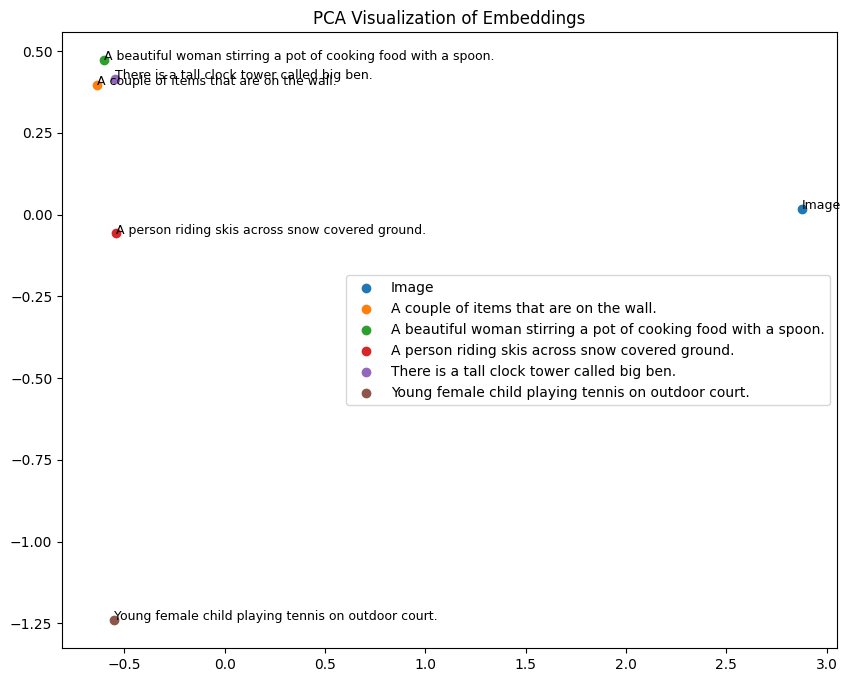


Best matching caption: Young female child playing tennis on outdoor court.


In [24]:

import os
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class VisionEncoder(torch.nn.Module):
    def __init__(self, backbone='resnet50'):
        super(VisionEncoder, self).__init__()
        if backbone == 'resnet50':
            resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.IMAGENET1K_V1')
            self.encoder = torch.nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        features = self.encoder(x)
        return features.squeeze(-1).squeeze(-1)

class TextEncoder(torch.nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, x, attention_mask):
        outputs = self.bert(x, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0]

class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim, output_dim=512):
        super(ProjectionHead, self).__init__()
        self.projection = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.projection(x)

def load_models():
    vision_encoder = VisionEncoder(backbone='resnet50')
    text_encoder = TextEncoder()
    projection_head_vision = ProjectionHead(input_dim=2048)
    projection_head_text = ProjectionHead(input_dim=768)
    vision_encoder.load_state_dict(torch.load('models/vision/vision_encoder_best.pth'))
    text_encoder.load_state_dict(torch.load('models/text/text_encoder_best.pth'))
    projection_head_vision.load_state_dict(torch.load('models/vision/projection_head.pth'))
    projection_head_text.load_state_dict(torch.load('models/text/projection_head.pth'))
    vision_encoder.eval()
    text_encoder.eval()
    projection_head_vision.eval()
    projection_head_text.eval()
    return vision_encoder, text_encoder, projection_head_vision, projection_head_text

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def tokenize_captions(captions, tokenizer, max_length=32):
    tokenized = tokenizer(
        captions,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    return tokenized['input_ids'], tokenized['attention_mask']

def compute_similarity(image_embedding, caption_embeddings):
    image_embedding = F.normalize(image_embedding, p=2, dim=-1)
    caption_embeddings = F.normalize(caption_embeddings, p=2, dim=-1)
    similarities = torch.matmul(image_embedding, caption_embeddings.T)
    return similarities.squeeze()

def visualize_embeddings(image_embeddings, caption_embeddings, captions):
    embeddings = torch.cat([image_embeddings, caption_embeddings], dim=0).detach().cpu().numpy()
    labels = ["Image"] + captions
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y, label=label)
        plt.text(x, y, label, fontsize=9)
    plt.legend()
    plt.title("PCA Visualization of Embeddings")
    plt.show()

def test_model(image_path, captions):
    vision_encoder, text_encoder, projection_head_vision, projection_head_text = load_models()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vision_encoder.to(device)
    text_encoder.to(device)
    projection_head_vision.to(device)
    projection_head_text.to(device)
    image = preprocess_image(image_path).to(device)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids, attention_mask = tokenize_captions(captions, tokenizer)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        image_features = vision_encoder(image)
        image_embedding = projection_head_vision(image_features)
    with torch.no_grad():
        text_features = text_encoder(input_ids, attention_mask=attention_mask)
        caption_embeddings = projection_head_text(text_features)
    similarities = compute_similarity(image_embedding, caption_embeddings)
    print("Similarity Scores:")
    for i, caption in enumerate(captions):
        print(f"Caption: {caption} -> Similarity: {similarities[i].item():.4f}")
    visualize_embeddings(image_embedding, caption_embeddings, captions)
    best_caption_idx = torch.argmax(similarities).item()
    best_caption = captions[best_caption_idx]
    print(f"\nBest matching caption: {best_caption}")
    return best_caption

if __name__ == "__main__":
    image_path = "test/000000007304.jpg"
    captions = [
        "A couple of items that are on the wall.",
        "A beautiful woman stirring a pot of cooking food with a spoon.",
        "A person riding skis across snow covered ground.",
        "There is a tall clock tower called big ben.",
        "Young female child playing tennis on outdoor court."
    ]
    test_model(image_path, captions)
